<a href="http://www.stfc.ac.uk/"> <img src="../../img/STFCLargeColour.jpg" width="50%" align="left"/></a>
<a href="https://www.addopt.org/"><img src="../../img/ADDoPT-logo-MAIN-with-text.png" width="300" height="200" align="right"/></a>


# An Artificial Neural Net Regressor

We have seen a [neural net classifier](DrugANN.ipynb) and discussed [how neural nets work](Neuron.ipynb). Now, let's use one for a regression problem.

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

import sys, os, time, pickle

import math
import numpy
sys.path.append('../../lib/')
#import rdkit_functions
import models
import pandas  
import pickle

from sklearn.model_selection import train_test_split

from rdkit import Chem

import matplotlib.pyplot as plt
models.hideAnswers
'imported'

'imported'

## Import the data
This is the data set of log solubilities. Thanks to Jarmo Huuskonen for these data. See J. Chem. Inf. Comput. Sci., 2000, 40, 773-777.

In [7]:
# log solubilities

df = pandas.read_csv('../../raw_data/solubility.csv')
df['molecule'] = df['SMILES'].apply(Chem.MolFromSmiles)
df.dropna(subset=['molecule']) # ignore any that can't be built
df = df.drop('ESOL predicted log(solubility:mol/L)', axis=1)
df = df.rename(columns={'measured log(solubility:mol/L)':'y'})
print(len(df))

training_set, test_set = train_test_split(df, test_size=0.1,
    random_state=0 # fixed seed because we want to compare performance later    
)
training_set.head()



1144


Compound ID      y                                   SMILES  \
706        gentisin -2.943       c1c(O)C2C(=O)C3cc(O)ccC3OC2cc1(OC)   
568        Dialifos -6.340  CCOP(=S)(OCC)SC(CCl)N2C(=O)c1ccccc1C2=O   
571        Diazinon -3.640         CCOP(=S)(OCC)Oc1cc(C)nc(n1)C(C)C   
64   1-Bromopentane -3.080                                  CCCCCBr   
708         glucose  0.740                     OCC1OC(O)C(O)C(O)C1O   

                                             molecule  
706  <rdkit.Chem.rdchem.Mol object at 0x7fec715483f0>  
568  <rdkit.Chem.rdchem.Mol object at 0x7fec7153d170>  
571  <rdkit.Chem.rdchem.Mol object at 0x7fec7153d0d0>  
64   <rdkit.Chem.rdchem.Mol object at 0x7fec71560670>  
708  <rdkit.Chem.rdchem.Mol object at 0x7fec71548490>

In [8]:
fingerprint = lambda m: Chem.rdmolops.RDKFingerprint(m, maxPath=3)
training_fp = training_set['molecule'].apply(fingerprint)
test_fp = test_set['molecule'].apply(fingerprint)

# pickle the data for future use
with open( "../../model_data/solubility_gm_fp.p", "wb" ) as f:
    pickle.dump( (training_fp, training_set['y'], test_fp, test_set['y'], training_set['molecule'], test_set['molecule']), f )
    
y_train = training_set['y']
test_y = test_set['y']

#with open( "../../model_data/solubility_gm.p", 'rb' ) as f:
#    (training_fp, _, y_train, test_fp, _, test_y) = pickle.load( f )

# convert fingerprints to numpy arrays
training_fp = numpy.array( list(map(numpy.array, training_fp)) )
test_fp = numpy.array( list(map(numpy.array, test_fp)) )
training_fp.shape

(1029, 2048)

## Build a Neural Network
Now the output layer is a weighted sum of its inputs from the second hidden layer. We also use leaky ReLUs for the second hidden layer, a "programmable" one in which the degree of leakiness is learnt.

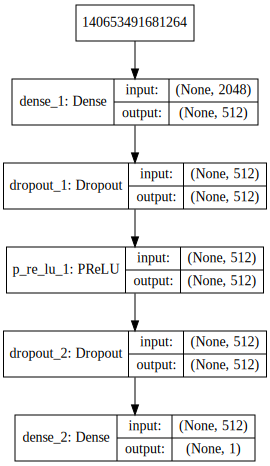

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, PReLU

model = Sequential() # multi-layer perceptron 
model.add(Dense(512, activation='relu', input_shape=(2048,), 
    kernel_regularizer=keras.regularizers.l2(0.005),
    kernel_initializer=keras.initializers.he_normal()
))
model.add(Dropout(0.5))  
model.add(
    PReLU(
        alpha_initializer=keras.initializers.he_normal(),
        alpha_regularizer=keras.regularizers.l2(0.005)
    )
)
model.add(Dropout(0.5))
model.add(
    Dense(1, activation='linear', 
      kernel_regularizer=keras.regularizers.l2(0.005)
    )
)  

model.compile(loss='mean_squared_error',   
              optimizer = keras.optimizers.SGD(
                  lr=0.01, # learning rate
                  momentum=0.9, decay=0.0, nesterov=True),
              )

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Train it



In [10]:

batch_size = 512
epochs = 200
history = model.fit(training_fp, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.1,  
    #callbacks=[keras.callbacks.EarlyStopping()]
)

Train on 926 samples, validate on 103 samples
Epoch 1/200
926/926 [==============================] - 1s 645us/step - loss: 15.9407 - val_loss: 9.4559
Epoch 2/200
926/926 [==============================] - 0s 152us/step - loss: 10.2774 - val_loss: 9.3952
Epoch 3/200
926/926 [==============================] - 0s 157us/step - loss: 9.3820 - val_loss: 8.3206
Epoch 4/200
926/926 [==============================] - 0s 160us/step - loss: 8.3146 - val_loss: 8.1185
Epoch 5/200
926/926 [==============================] - 0s 152us/step - loss: 8.1178 - val_loss: 7.9668
Epoch 6/200
926/926 [==============================] - 0s 158us/step - loss: 7.7744 - val_loss: 7.8844
Epoch 7/200
926/926 [==============================] - 0s 155us/step - loss: 7.8058 - val_loss: 7.8416
Epoch 8/200
926/926 [==============================] - 0s 151us/step - loss: 7.6856 - val_loss: 7.7800
Epoch 9/200
926/926 [==============================] - 0s 151us/step - loss: 7.5514 - val_loss: 7.6801
Epoch 10/200
926/926 [===

926/926 [==============================] - 0s 156us/step - loss: 3.8172 - val_loss: 4.4096
Epoch 158/200
926/926 [==============================] - 0s 160us/step - loss: 3.7501 - val_loss: 4.3942
Epoch 159/200
926/926 [==============================] - 0s 187us/step - loss: 3.7993 - val_loss: 4.3827
Epoch 160/200
926/926 [==============================] - 0s 158us/step - loss: 3.7650 - val_loss: 4.3701
Epoch 161/200
926/926 [==============================] - 0s 173us/step - loss: 3.7445 - val_loss: 4.3789
Epoch 162/200
926/926 [==============================] - 0s 151us/step - loss: 3.7142 - val_loss: 4.3550
Epoch 163/200
926/926 [==============================] - 0s 150us/step - loss: 3.7326 - val_loss: 4.3369
Epoch 164/200
926/926 [==============================] - 0s 148us/step - loss: 3.7510 - val_loss: 4.3294
Epoch 165/200
926/926 [==============================] - 0s 145us/step - loss: 3.6835 - val_loss: 4.3199
Epoch 166/200
926/926 [==============================] - 0s 147us/ste

## Display the results

R Squared 0.7438815827585181


/root/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


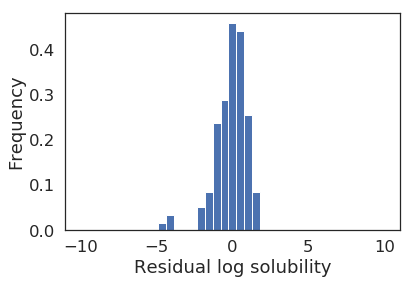

In [11]:

from sklearn import metrics

pr = model.predict(test_fp)
# that's a list of one-element lists, so extract the data we want
predicted = list(map(lambda lst: lst[0], pr ) )
print('R Squared', metrics.r2_score(test_y, predicted))

residuals = test_y - predicted

plt.figure()
plt.xlabel('Residual log solubility' )
plt.ylabel('Frequency')
plt.hist(residuals, bins=numpy.linspace(-10, 10, 40), normed=1)
plt.show()


If this graph showed outliers, then we might try [logcosh](https://keras.io/losses/) as the loss function. But this is actually very tight.


<div class="alert alert-warning" role="alert">
<b>Exercise:</b> Complete the exercises in <a href="../TrainingNN.ipynb">TrainingNN</a></div>

<div class="alert alert-warning" role="alert">
<b>Exercise:</b><br>
<ul>
    <li>Try with more or less regularization</li>
    <li>Replace the first hidden layer with a PReLU. Are the results better?</li>
As before with the classifier, for the regressor:
    <li>Try varying the learning rate</li>
    <li>The hidden layers have 512 nodes. Try wider or narrower layers.</li>
    <li>Try an extra hidden layer</li>
    <li>Try a <a href="https://keras.io/optimizers/">different optimizer</a></li>
</ul></div>

<div class="alert alert-warning" role="alert">
<b>Exercise:</b>
Save the model as a pickle. You will use it for a later exercise</div> 


<div class="alert alert-warning" role="alert">
<b>Exercise:</b><br>
<ul>
    <li>Using your saved pickle files for SVC and neural network classifier, compare the quality of the models with those made <a href="../ClassifierQuality.ipynb">earlier in the week</a>.</li>
    <li>Once you have picked a best model, please test it on our <a href="../TestClassifierModel.ipynb">excluded test set</a>.</li>
</ul></div>



[Up](../Welcome.ipynb)<br> [Neural Net Classifier](../DrugANN.ipynb) <br>
[Exercise](../TrainingNN.ipynb)
[Classical Statistics](../Optional/ClassicalStatistics.ipynb)<br>
[Next](../TestClassifierModel.ipynb)

---------------------------------------------------
Copyright STFC 2018